In [188]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm

np.random.seed(0)

In [189]:
def get_radar(xpos_pred):
    """Return Predicted Horizontal Distance and Measured Distance by Radar."""
    xvel_w = np.random.normal(0, 5)   # xvel_w: system noise of horizontal velocity [m/s].
    xvel_true = 100 + xvel_w          # xvel_true: true horizontal velocity [m/s].

    ypos_w = np.random.normal(0, 10)  # ypos_w: system noise of vertical position [m].
    ypos_true = 1000 + ypos_w         # ypos_true: true vertical position [m].

    xpos_pred = xpos_pred + xvel_true * dt                     # xpos_pred: predicted horizontal distance [m].

    rpos_v = xpos_pred * np.random.normal(0, 0.05)             # rpos_v: measurment noise of distance from radar.
    rpos_meas = np.sqrt(xpos_pred**2 + ypos_true**2) + rpos_v  # r: measured distance [m] (observable).

    return rpos_meas, xpos_pred

In [190]:
def fx(x_esti):
    return A @ x_esti

def hx(x_pred):
    z_pred = np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return np.array([z_pred])

In [207]:
def particle_filter(z_meas, x_esti, pt, wt):
    """Particle Filter Algorithm.
        - norm.pdf(x, mu, sigma):
            the pdf of the normal distribution with mean mu
            and standard deviation sigma, evaluated at the values x.
    """
    # (1) Predict Particles.
    pt = fx(pt) + np.random.randn(*pt.shape)

    # (2) Update Weights.
    wt = wt*norm.pdf(z_meas, hx(pt), 10)
    wt = wt / np.sum(wt)

    # (3) Estimate States.
    x = pt @ wt.T

    # (4) Resample Particles using Sequential Importance Resampling (SIR).
    wtc = np.cumsum(wt, axis=1)
    rpt = np.random.rand(Npt, 1)
    
    print(wt)
    print(wtc)
    print(rpt)
    print()
    
    
    return pt, wt

In [208]:
# Input parameters.
time_end = 20
dt = 0.05

In [209]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.eye(3) + dt * np.array([[0, 1, 0],
                               [0, 0, 0],
                               [0, 0, 0]])
# Initialization for estimation.
x_0 = np.array([0, 90, 1100])  # [horizontal position, horizontal velocity, vertical position].

# Initialization for particles.
#Npt = 1000
Npt = 3
pt = x_0.reshape(-1, 1) + 0.1 * x_0.reshape(-1, 1) * np.random.randn(1, Npt)
wt = np.ones((1, Npt)) / Npt

In [210]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)
rpos_esti_save = np.zeros(n_samples)
xvel_esti_save = np.zeros(n_samples)
rpos_meas_save = np.zeros(n_samples)

In [211]:
xpos_pred = 0
x_esti = None
#for i in range(n_samples):
for i in range(4):
    z_meas, xpos_pred = get_radar(xpos_pred)
    print()
    print("i", i)
    if i == 0:
        x_esti = x_0
    else:
        #x_esti, P = particle_filter(z_meas, x_esti, P)
        pt, wt = particle_filter(z_meas, x_esti, pt, wt)
        
    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]
    rpos_esti_save[i] = np.sqrt(x_esti[0]**2 + x_esti[2]**2)
    xvel_esti_save[i] = x_esti[1]
    rpos_meas_save[i] = z_meas


i 0

i 1
[[2.77828016e-03 4.78341268e-76 9.97221720e-01]]
[[0.00277828 0.00277828 1.        ]]
[[0.10022689]
 [0.91948261]
 [0.7142413 ]]


i 2
[[4.80873783e-005 2.74053497e-169 9.99951913e-001]]
[[4.80873783e-05 4.80873783e-05 1.00000000e+00]]
[[0.86638233]
 [0.97552151]
 [0.85580334]]


i 3
[[2.39917558e-007 3.86018653e-256 9.99999760e-001]]
[[2.39917558e-07 2.39917558e-07 1.00000000e+00]]
[[0.934214  ]
 [0.61396596]
 [0.5356328 ]]



FileNotFoundError: [Errno 2] No such file or directory: 'png/radar_ukf.png'

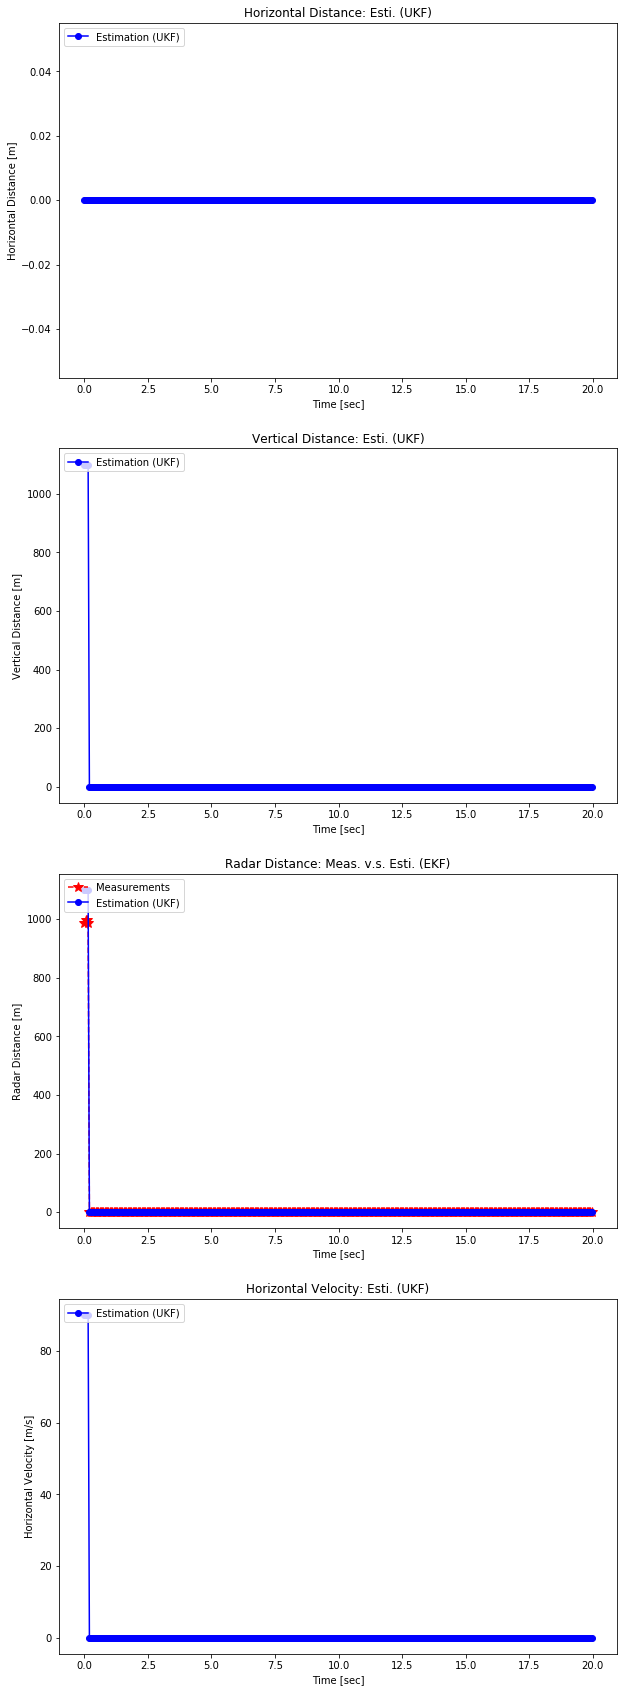

In [201]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))

plt.subplot(4, 1, 1)
plt.plot(time, xpos_esti_save, 'bo-', label='Estimation (UKF)')
plt.legend(loc='upper left')
plt.title('Horizontal Distance: Esti. (UKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Horizontal Distance [m]')

plt.subplot(4, 1, 2)
plt.plot(time, ypos_esti_save, 'bo-', label='Estimation (UKF)')
plt.legend(loc='upper left')
plt.title('Vertical Distance: Esti. (UKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Vertical Distance [m]')

plt.subplot(4, 1, 3)
plt.plot(time, rpos_meas_save, 'r*--', label='Measurements', markersize=10)
plt.plot(time, rpos_esti_save, 'bo-', label='Estimation (UKF)')
plt.legend(loc='upper left')
plt.title('Radar Distance: Meas. v.s. Esti. (EKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Radar Distance [m]')

plt.subplot(4, 1, 4)
plt.plot(time, xvel_esti_save, 'bo-', label='Estimation (UKF)')
plt.legend(loc='upper left')
plt.title('Horizontal Velocity: Esti. (UKF)')
plt.xlabel('Time [sec]')
plt.ylabel('Horizontal Velocity [m/s]')

plt.savefig('png/radar_ukf.png')

In [141]:
def normpdf_python(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1*(x-mu)**2/ (2*sigma**2) )

#def normpdf_python(x, mu, sigma):
#    return 1/

x = np.array([-2,-1,0,1,2])
#a = np.linspace(200, 220, 100)
#c = norm.pdf(x, 2, 1)
c = normpdf_python(x, 0, 1)
c

array([0.05399097, 0.24197072, 0.39894228, 0.24197072, 0.05399097])